### Based on Tutorial
https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [1]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [2]:
# Load data
data=pd.read_csv("../common-data/Reviews.csv")

In [3]:
# Checking data
data.head

<bound method NDFrame.head of          Id   ProductId          UserId                      ProfileName  \
0         1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1         2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2         3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3         4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4         5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   
...     ...         ...             ...                              ...   
9995   9996  B000P41A28  A3A63RACXR1XIL            A. Boodhoo "deaddodo"   
9996   9997  B000P41A28    A5VVRGL8JA7R                             Adam   
9997   9998  B000P41A28  A2TGDTJ8YCU6PD                          geena77   
9998   9999  B000P41A28   AUV4GIZZE693O              Susan Coe "sueysis"   
9999  10000  B000P41A28   A82WIMR4RSVLI                       Emrose mom   

      HelpfulnessNumerator  HelpfulnessDenominator  Score

In [4]:
# Checking data stats
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      10000 non-null  int64 
 1   ProductId               10000 non-null  object
 2   UserId                  10000 non-null  object
 3   ProfileName             10000 non-null  object
 4   HelpfulnessNumerator    10000 non-null  int64 
 5   HelpfulnessDenominator  10000 non-null  int64 
 6   Score                   10000 non-null  int64 
 7   Time                    10000 non-null  int64 
 8   Summary                 10000 non-null  object
 9   Text                    10000 non-null  object
dtypes: int64(5), object(5)
memory usage: 781.4+ KB


In [5]:
# Checking data and cleaning
data.drop_duplicates(subset=['Text'],inplace=True)  #dropping duplicates
data.dropna(axis=0,inplace=True)   #dropping na
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9513 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Id                      9513 non-null   int64 
 1   ProductId               9513 non-null   object
 2   UserId                  9513 non-null   object
 3   ProfileName             9513 non-null   object
 4   HelpfulnessNumerator    9513 non-null   int64 
 5   HelpfulnessDenominator  9513 non-null   int64 
 6   Score                   9513 non-null   int64 
 7   Time                    9513 non-null   int64 
 8   Summary                 9513 non-null   object
 9   Text                    9513 non-null   object
dtypes: int64(5), object(5)
memory usage: 817.5+ KB


In [6]:
# Data cleaning
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

"""
Convert everything to lowercase
Remove HTML tags
Contraction mapping
Remove (‘s)
Remove any text inside the parenthesis ( )
Eliminate punctuations and special characters
Remove stopwords
"""

stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    return (" ".join(tokens)).strip()
  

In [7]:
# Clean text
cleaned_text = []
for t in data['Text']:
    cleaned_text.append(text_cleaner(t))
data['Cleaned_Text']=cleaned_text
# Clean summary text
cleaned_text = []
for t in data['Summary']:
    cleaned_text.append(text_cleaner(t))
data['Cleaned_Summary']=cleaned_text

In [8]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Cleaned_Text,Cleaned_Summary
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,advertised
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy


In [9]:
data['Cleaned_Summary'] = data['Cleaned_Summary'].apply(lambda x : '_START_ '+ x + ' _END_')

In [10]:
# Printing cleaned text and summary
for i in range(5):
    print("Review:",data['Cleaned_Text'][i])
    print("Summary:",data['Cleaned_Summary'][i])
    print("\n")

Review: bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
Summary: _START_ good quality dog food _END_


Review: product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
Summary: _START_ advertised _END_


Review: confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story c lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
Summary: _START_ delight says _END_


Review: looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
Summary: _START_ cough medicine _END_


Review: great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
Summary

### Learning Summary

In [11]:
max_len_text=80 
max_len_summary=10

In [12]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(data['Cleaned_Text'],data['Cleaned_Summary'],test_size=0.1,random_state=0,shuffle=True) 

In [13]:
# Text tokenizer 
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr,  maxlen=max_len_text, padding='post') 
x_val   =   pad_sequences(x_val, maxlen=max_len_text, padding='post')

x_voc_size   =  len(x_tokenizer.word_index) +1

In [14]:
# Summary tokenizer
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

#convert summary sequences into integer sequences
y_tr    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr, maxlen=max_len_summary, padding='post')
y_val   =   pad_sequences(y_val, maxlen=max_len_summary, padding='post')

y_voc_size  =   len(y_tokenizer.word_index) +1

In [15]:
# Attention
from attention import AttentionLayer

In [16]:
from keras import backend as K 
K.clear_session() 
latent_dim = 500 

# Encoder 
encoder_inputs = Input(shape=(max_len_text,)) 
enc_emb = Embedding(x_voc_size, latent_dim,trainable=True)(encoder_inputs) 

#LSTM 1 
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 

#LSTM 2 
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2) 

# Set up the decoder. 
decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(y_voc_size, latent_dim,trainable=True) 
dec_emb = dec_emb_layer(decoder_inputs) 

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 80)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 80, 500)      8536000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 80, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
_______________________________________________________________________________________

In [17]:
# Setting up and running the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=5,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))


Epoch 1/5
17/17 [==============================] - 299s 18s/step - loss: 3.5669 - val_loss: 2.3398
Epoch 2/5
17/17 [==============================] - 308s 18s/step - loss: 2.5066 - val_loss: 2.1513
Epoch 3/5
17/17 [==============================] - 307s 18s/step - loss: 2.3363 - val_loss: 2.0657
Epoch 4/5
17/17 [==============================] - 308s 18s/step - loss: 2.2758 - val_loss: 2.0557
Epoch 5/5
17/17 [==============================] - 308s 18s/step - loss: 2.2318 - val_loss: 2.0383


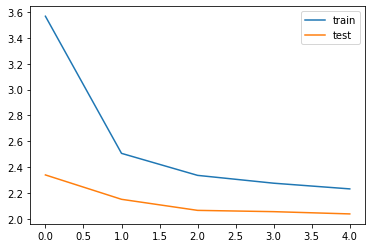

In [18]:
from matplotlib import pyplot 
pyplot.plot(history.history['loss'], label='train') 
pyplot.plot(history.history['val_loss'], label='test') 
pyplot.legend() 
pyplot.show()

### Deconding results

In [19]:
reverse_target_word_index=y_tokenizer.index_word 
reverse_source_word_index=x_tokenizer.index_word 
target_word_index=y_tokenizer.word_index

In [20]:
print(target_word_index)

{'start': 1, 'end': 2, 'great': 3, 'good': 4, 'best': 5, 'coffee': 6, 'love': 7, 'product': 8, 'taste': 9, 'delicious': 10, 'tea': 11, 'flavor': 12, 'food': 13, 'excellent': 14, 'dog': 15, 'yummy': 16, 'tasty': 17, 'chips': 18, 'like': 19, 'price': 20, 'ever': 21, 'hot': 22, 'favorite': 23, 'chocolate': 24, 'stuff': 25, 'free': 26, 'better': 27, 'k': 28, 'healthy': 29, 'sweet': 30, 'perfect': 31, 'awesome': 32, 'loves': 33, 'cup': 34, 'snack': 35, 'nice': 36, 'really': 37, 'mix': 38, 'bad': 39, 'yum': 40, 'one': 41, 'quality': 42, 'tasting': 43, 'gluten': 44, 'cocoa': 45, 'wonderful': 46, 'tastes': 47, 'easy': 48, 'little': 49, 'cups': 50, 'cat': 51, 'much': 52, 'buy': 53, 'cats': 54, 'dogs': 55, 'organic': 56, 'drink': 57, 'ok': 58, 'treat': 59, 'baby': 60, 'sugar': 61, 'treats': 62, 'soda': 63, 'pretty': 64, 'alternative': 65, 'fresh': 66, 'way': 67, 'works': 68, 'amazing': 69, 'water': 70, 'value': 71, 'popcorn': 72, 'cookies': 73, 'low': 74, 'find': 75, 'sauce': 76, 'fantastic': 77

In [21]:
print (reverse_target_word_index)

{1: 'start', 2: 'end', 3: 'great', 4: 'good', 5: 'best', 6: 'coffee', 7: 'love', 8: 'product', 9: 'taste', 10: 'delicious', 11: 'tea', 12: 'flavor', 13: 'food', 14: 'excellent', 15: 'dog', 16: 'yummy', 17: 'tasty', 18: 'chips', 19: 'like', 20: 'price', 21: 'ever', 22: 'hot', 23: 'favorite', 24: 'chocolate', 25: 'stuff', 26: 'free', 27: 'better', 28: 'k', 29: 'healthy', 30: 'sweet', 31: 'perfect', 32: 'awesome', 33: 'loves', 34: 'cup', 35: 'snack', 36: 'nice', 37: 'really', 38: 'mix', 39: 'bad', 40: 'yum', 41: 'one', 42: 'quality', 43: 'tasting', 44: 'gluten', 45: 'cocoa', 46: 'wonderful', 47: 'tastes', 48: 'easy', 49: 'little', 50: 'cups', 51: 'cat', 52: 'much', 53: 'buy', 54: 'cats', 55: 'dogs', 56: 'organic', 57: 'drink', 58: 'ok', 59: 'treat', 60: 'baby', 61: 'sugar', 62: 'treats', 63: 'soda', 64: 'pretty', 65: 'alternative', 66: 'fresh', 67: 'way', 68: 'works', 69: 'amazing', 70: 'water', 71: 'value', 72: 'popcorn', 73: 'cookies', 74: 'low', 75: 'find', 76: 'sauce', 77: 'fantastic'

In [23]:
# encoder inference
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# decoder inference
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Final decoder model
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

In [24]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Choose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [25]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
      if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
        newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
      if(i!=0):
        newString=newString+reverse_source_word_index[i]+' '
    return newString

In [26]:
import sys

In [27]:
for i in range(10):
# for i in range(len(x_val)):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    try:
        print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    except: # catch *all* exceptions
        print("Predicted summary: some issue.")
    print("\n")

Review: wellness never anymore amazing percent eating real food along sawdust chicken hearts still feed eating twice day cup total eating three times day cup total eats morning walks away eats hours later looks dinner twelve hours initial feeding knocking things dad papers desk deliberately spilled water floor incredible feel bad long really thought dramatic whatever genuinely hungry eating real food cat favor buy food made real ingredients things would eat wellness halo innova evo whatever figure please feed cat garbage 
Original summary: filler food empty leaves cat always 
Predicted summary: some issue.


Review: like smoked sweet paprika better styles sweet paprika came fresh reasonable price 
Original summary: smoked paprika 
Predicted summary: some issue.


Review: caribou coffees weak one delicious exception right revv emeril bold van houtte eclipse dark bold coffee without tasting burned bitter 
Original summary: wonderful dark coffee 
Predicted summary: some issue.


Review: b